In [2]:
import os
from collections import Counter
from PIL import Image, ImageEnhance
import numpy as np
from skimage.restoration import denoise_bilateral
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('dark_background')


**_Checking Imbalance_**

Class Healthy has 458 images in Train
Class Powdery has 430 images in Train
Class Rust has 434 images in Train
Class Healthy has 20 images in Validation
Class Powdery has 20 images in Validation
Class Rust has 20 images in Validation
Class Healthy has 50 images in Test
Class Powdery has 50 images in Test
Class Rust has 50 images in Test


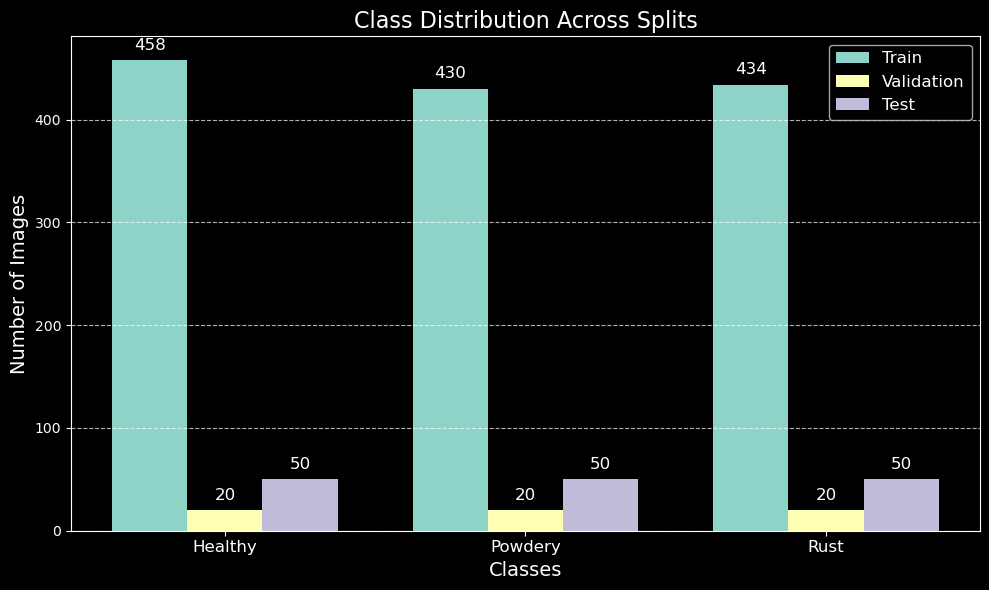

In [8]:
def check_imbalance(data_dir):
    class_counts = {'Train': {}, 'Validation': {}, 'Test': {}}
    for split in ['Train', 'Validation', 'Test']:
        split_dir = os.path.join(data_dir, split, split)
        for class_name in ['Healthy', 'Powdery', 'Rust']:
            class_dir = os.path.join(split_dir, class_name)
            if split not in class_counts:
                class_counts[split] = {}
            class_counts[split][class_name] = len(os.listdir(class_dir))
            print(f"Class {class_name} has {class_counts[split][class_name]} images in {split}")
    return class_counts

def plot_class_distribution(class_counts):
    splits = list(class_counts.keys())
    classes = list(class_counts[splits[0]].keys())
    
    # Data preparation for plotting
    data = {split: [class_counts[split][cls] for cls in classes] for split in splits}
    
    x = range(len(classes))
    width = 0.25  # Width of each bar

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotting bars and annotations
    for i, split in enumerate(splits):
        bars = ax.bar(
            [pos + i * width for pos in x], 
            data[split], 
            width, 
            label=split
        )

        # Adding annotations to each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # Position x
                height + 10,  # Position y, slightly above the bar
                str(height),  # Text value
                ha='center',  # Horizontal alignment
                fontsize=12  # Font size
            )

    # Customizing the plot
    ax.set_xlabel("Classes", fontsize=14)
    ax.set_ylabel("Number of Images", fontsize=14)
    ax.set_title("Class Distribution Across Splits", fontsize=16)
    ax.set_xticks([pos + width for pos in x])
    ax.set_xticklabels(classes, fontsize=12)
    ax.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Directory containing dataset
data_dir = 'Dataset'

# Check imbalance and plot
class_counts = check_imbalance(data_dir)
plot_class_distribution(class_counts)

In [10]:
def augment_images(data_dir):
    train_dir = os.path.join(data_dir, 'Train','Train')
    for class_name in ['Healthy', 'Powdery', 'Rust']:
        class_dir = os.path.join(train_dir, class_name)

        original_images = [f for f in os.listdir(class_dir) 
                         if f.endswith(('.jpg', '.png')) 
                         and not f.startswith(('flipped_', 'rotated_', 'zoomed_', 'scaled_'))]
        
        for filename in original_images:  
            image_path = os.path.join(class_dir, filename)
            image = Image.open(image_path)

            # First remove noise
            denoised_image = remove_noise(image, kernel_size=3)
            
            # Then adjust contrast
            adjusted_image = adjust_contrast(denoised_image)
            # Save the denoised and contrast-adjusted image
            adjusted_image.save(image_path)

            # Create augmentations from the processed image
            flipped_image = adjusted_image.transpose(Image.FLIP_LEFT_RIGHT)
            flipped_image.save(os.path.join(class_dir, f'flipped_{filename}'))

            rotated_image = adjusted_image.rotate(45)
            rotated_image.save(os.path.join(class_dir, f'rotated_{filename}'))

            zoomed_image = zoom_image(adjusted_image, 1.2)
            zoomed_image.save(os.path.join(class_dir, f'zoomed_{filename}'))

            scaled_image = scale_image(adjusted_image, 0.8)
            scaled_image.save(os.path.join(class_dir, f'scaled_{filename}'))

def zoom_image(image, zoom_factor):
    width, height = image.size
    x = int(width * (1 - 1/zoom_factor) / 2)  
    y = int(height * (1 - 1/zoom_factor) / 2) 
    cropped_image = image.crop((x, y, width - x, height - y))
    return cropped_image.resize((width, height), Image.LANCZOS)

def scale_image(image, scale_factor):
    width, height = image.size
    new_size = (int(width * scale_factor), int(height * scale_factor))
    return image.resize(new_size, Image.LANCZOS)

def adjust_contrast(image):

    contrast_factor = np.random.uniform(1.4)
    enhancer = ImageEnhance.Contrast(image)
    return enhancer.enhance(contrast_factor)

def remove_noise(image, kernel_size=3):
    img_array = np.array(image)
    from scipy.ndimage import median_filter
    denoised = median_filter(img_array, size=kernel_size)
    
    return Image.fromarray(denoised)

data_dir = 'Dataset'
augment_images(data_dir)

In [11]:
def image_enhancements (data_dir):
    for path in ['Test','Validation']:
        directory = os.path.join(data_dir,path,path)
        for class_name in ['Healthy','Powdery','Rust']:
            final_directory = os.path.join(directory,class_name)
            original_images = [f for f in os.listdir(final_directory) if f.endswith(('.jpg', '.png'))]
            
            for file_name in original_images:
                image_path = os.path.join(final_directory,file_name)
                image = Image.open(image_path)

                denoised_image = remove_noise(image, kernel_size=3)
                
                adjusted_image = adjust_contrast(image)

                adjusted_image.save(image_path)

image_enhancements('Dataset')

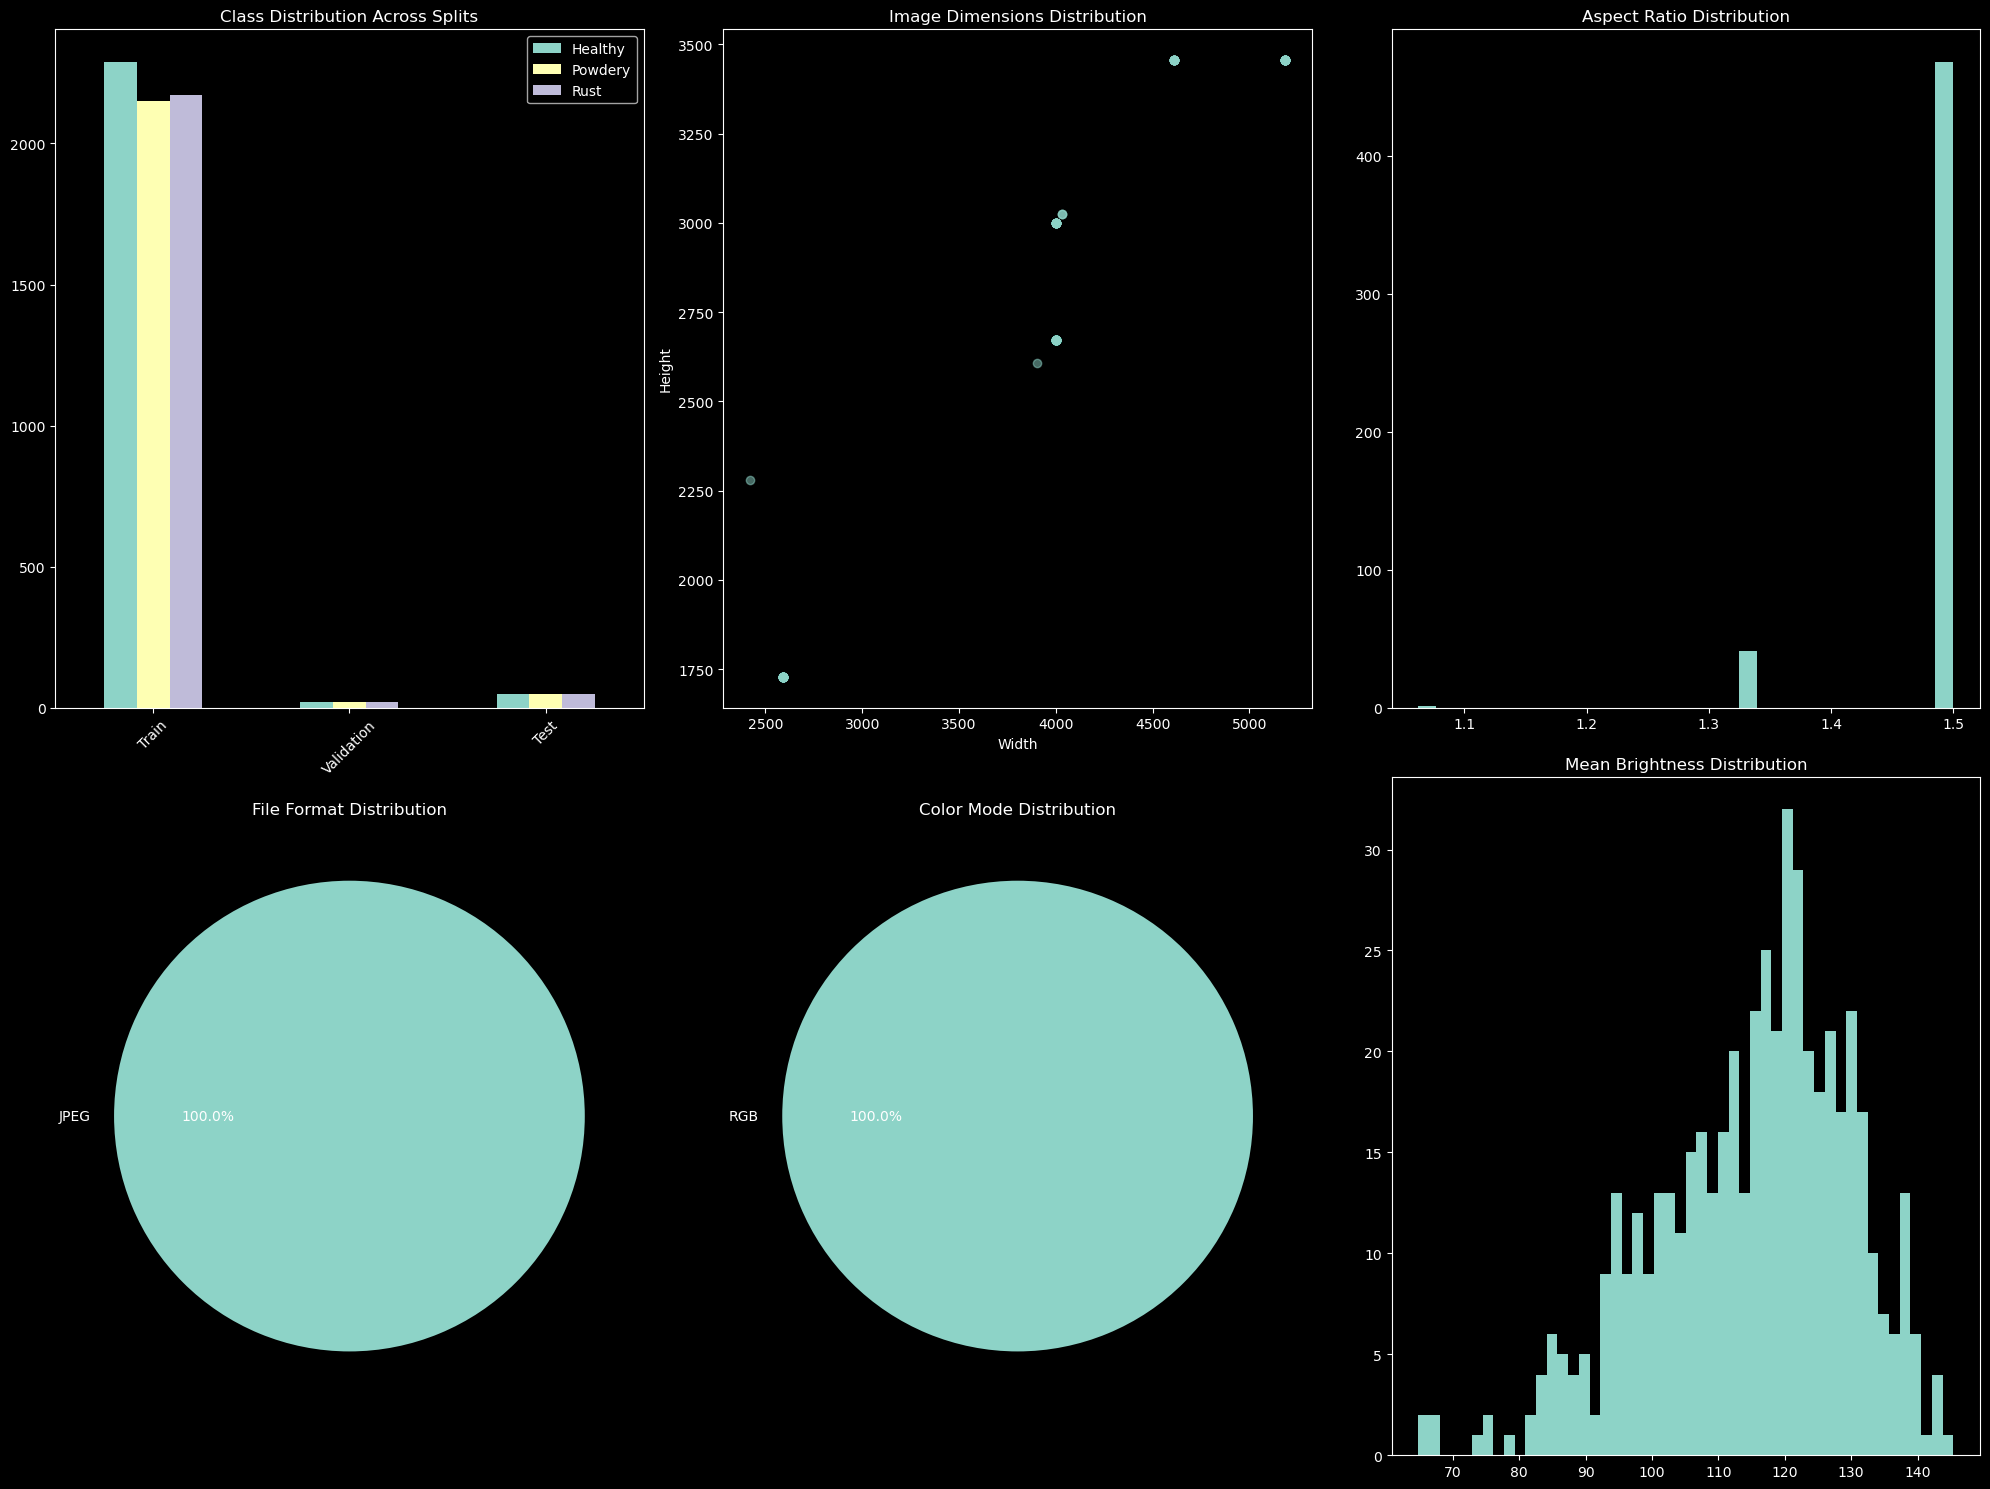

: 

In [12]:
def perform_image_eda(data_dir):

    stats = {
        'class_distribution': {},
        'image_sizes': [],
        'aspect_ratios': [],
        'file_formats': [],
        'color_modes': [],
        'mean_brightness': []
    }
    
    for split in ['Train', 'Validation', 'Test']:
        split_dir = os.path.join(data_dir, split, split)
        stats['class_distribution'][split] = {}
        
        for class_name in ['Healthy', 'Powdery', 'Rust']:
            class_dir = os.path.join(split_dir, class_name)
            images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
            
            stats['class_distribution'][split][class_name] = len(images)
            
            for img_name in images[:100]: 
                img_path = os.path.join(class_dir, img_name)
                with Image.open(img_path) as img:
                    # Image size
                    stats['image_sizes'].append(img.size)
                    
                    # Aspect ratio
                    aspect_ratio = img.size[0] / img.size[1]
                    stats['aspect_ratios'].append(aspect_ratio)
                    
                    # File format
                    stats['file_formats'].append(img.format)
                    
                    # Color mode
                    stats['color_modes'].append(img.mode)
                    
                    # Mean brightness
                    brightness = np.array(img).mean()
                    stats['mean_brightness'].append(brightness)
    
    return stats

def visualize_eda(stats):
    """
    Visualize EDA results using matplotlib
    """
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Class Distribution
    plt.subplot(2, 3, 1)
    df_dist = pd.DataFrame(stats['class_distribution']).T
    df_dist.plot(kind='bar', ax=plt.gca())
    plt.title('Class Distribution Across Splits')
    plt.xticks(rotation=45)
    
    # 2. Image Sizes
    plt.subplot(2, 3, 2)
    widths, heights = zip(*stats['image_sizes'])
    plt.scatter(widths, heights, alpha=0.5)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title('Image Dimensions Distribution')
    
    # 3. Aspect Ratios
    plt.subplot(2, 3, 3)
    plt.hist(stats['aspect_ratios'], bins=30)
    plt.title('Aspect Ratio Distribution')
    
    # 4. File Formats
    plt.subplot(2, 3, 4)
    format_counts = Counter(stats['file_formats'])
    plt.pie(format_counts.values(), labels=format_counts.keys(), autopct='%1.1f%%')
    plt.title('File Format Distribution')
    
    # 5. Color Modes
    plt.subplot(2, 3, 5)
    mode_counts = Counter(stats['color_modes'])
    plt.pie(mode_counts.values(), labels=mode_counts.keys(), autopct='%1.1f%%')
    plt.title('Color Mode Distribution')
    
    # 6. Brightness Distribution
    plt.subplot(2, 3, 6)
    plt.hist(stats['mean_brightness'], bins=50)
    plt.title('Mean Brightness Distribution')
    
    plt.tight_layout()
    plt.show()

data_dir = 'Dataset'
stats = perform_image_eda(data_dir)
visualize_eda(stats)